## Special features

In [1]:
# imports
import mace, py3Dmol
from rdkit import Chem
from rdkit.Chem import Draw

# view 2D (not needed, just for the better sphinx thumbmails)
def draw_mol(mol, size = (300, 300)):
    '''Returns PIL Image'''
    return Draw.MolToImage(mol, size = size)

# view 3D structures
def view_complex(X, confId = 0):
    '''Shows molecule corresponding to the SMILES'''
    view = py3Dmol.view(width = 360, height = 360)
    view.addModel(X.ToXYZBlock(confId = confId), 'xyz')
    view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.3}})
    view.setBackgroundColor('white')
    view.zoomTo()
    view.show()## Special features

### Adding substituents

One of the most popular problems in computational chemistry is the search for the most efficient system by introducing various substituents to the core structure. To make such tasks easier, MACE contains functionality for introducing substituents to both ligands and complexes. To use it, one need to start with getting ChemAxon SMILES of the ligand with R/R1/R2/etc substituents:

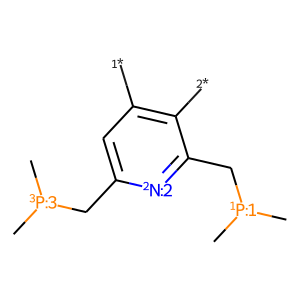

In [2]:
# check ligand
ligand = 'C[P:3](C)CC1=CC([*])=C([*])C(C[P:1](C)C)=[N:2]1 |$;;;;;;;_R1;;_R2;;;;;;$,c:14,t:4,7|'
L = mace.MolFromSmiles(ligand)
draw_mol(L)

or to use specify substituents as dummy atoms in RDKit SMILES format. To add substituents to the ligand one need to use `mace.AddSubsToMol` function:

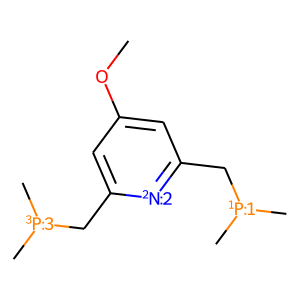

In [3]:
# add subs to ligand
subs = {'R1': mace.MolFromSmiles('[*]OC'),
        'R2': mace.MolFromSmiles('[*][H]')}
ligand_sub = mace.AddSubsToMol(L, subs)
draw_mol(ligand_sub)

For the complex, the same procedure is a little trickier:

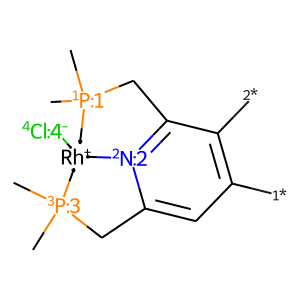

In [4]:
# get complex with dummies
core = mace.ComplexFromLigands([ligand, '[Cl-:4]'], '[Rh+]', 'SP')
draw_mol(core.mol)

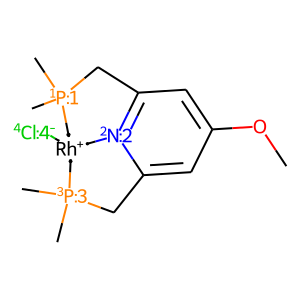

In [5]:
# get complex with subs
X = mace.ComplexFromMol(mace.AddSubsToMol(core.mol, subs), core.geom)
draw_mol(X.mol)

### Constrained embedding

When analyzing conformations of complexes with one core and different substituents, constrained embedding can be a nice solution. The idea is to fix the geometry of the core and optimize coordinates of other atoms. In MACE this is implemented in the `AddConstrainedConformer` / `AddConstrainedConformers` methods. Compared to the `AddConstrainedConformer` / `AddConstrainedConformers` methods, they take additional parameter `core` which must be (1) a `Complex` object, (2) substructure of the current `Complex`, and (3) must have at least one generated conformer:

In [6]:
# get 3D for core complex from previous subsection
core.AddConformer()
view_complex(core)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [7]:
# constrained embedding
X.AddConstrainedConformer(core, confId = core.GetMinEnergyConfId(0))
view_complex(X)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Currently MACE supports monovalent substituents only.

### Prepare ligands for MolSimplify

Like MACE, [MolSimplify](https://github.com/hjkgrp/molSimplify) is a package for the automated screening and discovery of new inorganic molecules. It uses OpenBabel as 3D embedding engine, and fails generating conformers of complex multidentate ligands from SMILES. However, it works perfectly fine if the ligand already have pregenerated geometry which in most cases has to be prepared manually.

Lucky for us, MACE can be used to automatically generate conformations of coordinated ligands with a structure of almost any complexity. For the purpose, one must generate 3D coordinated for any complex containing desired ligand, and cut it from the complex using the `GetBondedLigand` method (`num` parameter is an isotopic number of the ligand's donor atom):

In [8]:
# generate complex and 3D coords
ligands = ['[n:1]1ccccc1-c([n:2]1)cccc1CNCC[P:6](C)C', '[C-:3]#[O+]', '[C-:4]#[O+]', '[C-:5]#[O+]']
num = 1
X = mace.ComplexFromLigands(ligands, '[Ru+2]', 'OH')
Xs = X.AddConformers(numConfs = 10)

# view best conf
idx_min = X.GetMinEnergyConfId(0)
view_complex(X, idx_min)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [9]:
# get ligand in coordinated state
mol = X.GetBondedLigand(num)

def view_mol(mol, confId = 0):
    '''Shows molecule corresponding to the SMILES'''
    view = py3Dmol.view(width = 360, height = 360)
    view.addModel(Chem.MolToMolBlock(mol, confId = confId), 'mol')
    view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.3}})
    view.setBackgroundColor('white')
    view.zoomTo()
    view.show()
    
    return

# view
view_mol(mol, idx_min)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Obtained conformer can be saved in `mol` / `xyz` format and stored in the molSimplify library of ligands.